In [118]:
import os
import torch
import numpy as np
import random

def seed_everything(seed):
    """
    Set random seed for reproducibility
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🔒 Locked Random Seed: {seed}")


In [119]:



def seed_everything_random():
    """
    Tạo random seed, set seed đó, và return seed để bạn biết
    """
    # Tạo random seed
    random_seed = random.randint(0, 999999)
    
    # Set seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # Để reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    return random_seed


In [120]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from preprocess import get_sampler

In [121]:
#load data
df_men =pd.read_csv(r"C:\Users\Lenovo\Documents\Rankability uplift modeling\Hillstrom-Men.csv")
df_men = df_men.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_men.isnull().sum())
print ("---------------------------")
print(df_men.dtypes)
print ("---------------------------")
print ("labels:")
print(df_men.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_men.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42613, 12)


In [130]:
#Hillstrom-men
#split num and cate
cate_cols = ['zip_code', 'channel']
df_men["history_segment"] =df_men["history_segment"].map({
    "1) $0 - $100": 1,
    "2) $100 - $200": 2,
    "3) $200 - $350": 3,
    "4) $350 - $500": 4,
    "5) $500 - $750": 5,
    "6) $750 - $1,000": 6,
    "7) $1,000 +": 7
})
num_cols = ['recency', 'history_segment', 'history']
#split x y t
y_men = df_men["spend"]
t_men = df_men["treatment"]
x_men = df_men.drop(columns=["spend", "treatment", "visit", "conversion"])

x_men_encode = pd.get_dummies(x_men, columns=cate_cols, drop_first=True)
x_men_encode = x_men_encode.astype(float)

#train test split - stratify CHỈ bằng treatment
x_men_train, x_men_test, t_men_train, t_men_test, y_men_train, y_men_test = train_test_split(
    x_men_encode, t_men.values, y_men.values,
    test_size=0.3, random_state=42, stratify = t_men
)

x_men_train, x_men_val, t_men_train, t_men_val, y_men_train, y_men_val = train_test_split(
    x_men_train, t_men_train, y_men_train,
    test_size=(1/7), random_state=42, stratify= t_men_train
)

#scale - Fit chỉ trên train set (NO LEAKAGE HERE)
scaler = StandardScaler()
x_men_train= scaler.fit_transform(x_men_train)
x_men_val = scaler.transform(x_men_val)
x_men_test = scaler.transform(x_men_test)

print ("✅ Train/Val/Test split with stratification ONLY by treatment (NO DATA LEAKAGE)")
print (f"Train: {x_men_train.shape}, Val: {x_men_val.shape}, Test: {x_men_test.shape}")
print (f"Treatment distribution - Train: {np.mean(t_men_train):.2%}, Val: {np.mean(t_men_val):.2%}, Test: {np.mean(t_men_test):.2%}")
print (f"Spend mean - Train: {np.mean(y_men_train):.2f}, Val: {np.mean(y_men_val):.2f}, Test: {np.mean(y_men_test):.2f}")

print (x_men_train[:10])

✅ Train/Val/Test split with stratification ONLY by treatment (NO DATA LEAKAGE)
Train: (25567, 10), Val: (4262, 10), Test: (12784, 10)
Treatment distribution - Train: 50.00%, Val: 50.00%, Test: 50.00%
Spend mean - Train: 1.00, Val: 0.95, Test: 1.14
[[-1.36323828         nan -0.65534372 -1.11309822  0.90903506 -1.00655333
  -0.89924668  1.22273126 -0.87900784  1.12185957]
 [ 0.63260109         nan -0.31367375 -1.11309822  0.90903506 -1.00655333
  -0.89924668  1.22273126 -0.87900784  1.12185957]
 [ 0.34748118         nan -0.4344948   0.89839331 -1.10006758  0.99348934
  -0.89924668  1.22273126  1.13764628 -0.89137716]
 [ 1.48796081         nan -0.82948671  0.89839331 -1.10006758 -1.00655333
   1.11204191 -0.8178412   1.13764628 -0.89137716]
 [-1.07811837         nan -0.41208699 -1.11309822  0.90903506 -1.00655333
  -0.89924668  1.22273126 -0.87900784  1.12185957]
 [ 0.06236127         nan -0.28019986  0.89839331 -1.10006758 -1.00655333
  -0.89924668  1.22273126  1.13764628 -0.89137716]
 [

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [123]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_men_train_t = to_tensor(x_men_train)
x_men_val_t = to_tensor(x_men_val)
x_men_test_t = to_tensor(x_men_test)

y_men_train_t = to_tensor(y_men_train).unsqueeze(1)
y_men_val_t = to_tensor(y_men_val).unsqueeze(1)
y_men_test_t = to_tensor(y_men_test).unsqueeze(1)

t_men_train_t = to_tensor(t_men_train.astype(float)).unsqueeze(1)
t_men_val_t = to_tensor(t_men_val.astype(float)).unsqueeze(1)
t_men_test_t = to_tensor(t_men_test.astype(float)).unsqueeze(1)

# sampler = get_sampler(y_men_train_t, target_positive_ratio=0.2)

#Data loader
train_dataset = TensorDataset(x_men_train_t, t_men_train_t, y_men_train_t)
val_dataset = TensorDataset(x_men_val_t, t_men_val_t, y_men_val_t)
test_dataset = TensorDataset(x_men_test_t, t_men_test_t, y_men_test_t)

batch_size = 6400
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_men_train_t.shape}; y ={y_men_train_t.shape}; t={t_men_train_t.shape}")
print (f"Shape of val: x={x_men_val_t.shape}; y={y_men_val_t.shape}; t={t_men_val_t.shape}")
print (f"Shape of test: x={x_men_test_t.shape}; y={y_men_test_t.shape}; t={t_men_test_t.shape}")

-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25567, 10]); y =torch.Size([25567, 1]); t=torch.Size([25567, 1])
Shape of val: x=torch.Size([4262, 10]); y=torch.Size([4262, 1]); t=torch.Size([4262, 1])
Shape of test: x=torch.Size([12784, 10]); y=torch.Size([12784, 1]); t=torch.Size([12784, 1])


Evaluation metrics

In [124]:
from metrics import auuc, auqc, lift, krcc

Build Model

In [125]:
from dragonnet import Dragonnet

In [126]:
print("📊 Data Distribution Check:")
print(f"Y train: mean={y_men_train.mean():.4f}, std={y_men_train.std():.4f}")
print(f"Y train zeros: {(y_men_train == 0).sum()} / {len(y_men_train)} ({(y_men_train == 0).sum()/len(y_men_train)*100:.1f}%)")
print(f"\nTreatment balance:")
print(f"  Train: {(t_men_train == 1).sum()} treated, {(t_men_train == 0).sum()} control")
print(f"  Test:  {(t_men_test == 1).sum()} treated, {(t_men_test == 0).sum()} control")

📊 Data Distribution Check:
Y train: mean=1.0015, std=14.5993
Y train zeros: 25338 / 25567 (99.1%)

Treatment balance:
  Train: 12784 treated, 12783 control
  Test:  6392 treated, 6392 control


In [127]:
seed = seed_everything_random()
print(f"Using seed: {seed}")

print(f"Experiment completed with seed: {seed}")

Using seed: 503797
Experiment completed with seed: 503797


In [128]:
# seed = 10
# seed_everything(seed)

In [129]:
dragonnet = Dragonnet(input_dim=x_men_train_t.shape[1], epochs=25, alpha=1, beta=1, learning_rate=1e-3, tarrreg_start_epoch=0, early_stop_metric="qini", use_ema=False, patience=10, ema_alpha=0.15, weight_decay=1e-4)
dragonnet.fit(train_loader, val_loader)

print ("Complete training")

🔃🔃🔃Begin training Dragonnet🔃🔃🔃
📊 Strategy: Train for 25 epochs, then select model with best Qini score


KeyboardInterrupt: 

Evaluating baseline🔃🔃🔃


c:\Users\Lenovo\Documents\Rankability uplift modeling\Baseline\dragonnet.py:210: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)


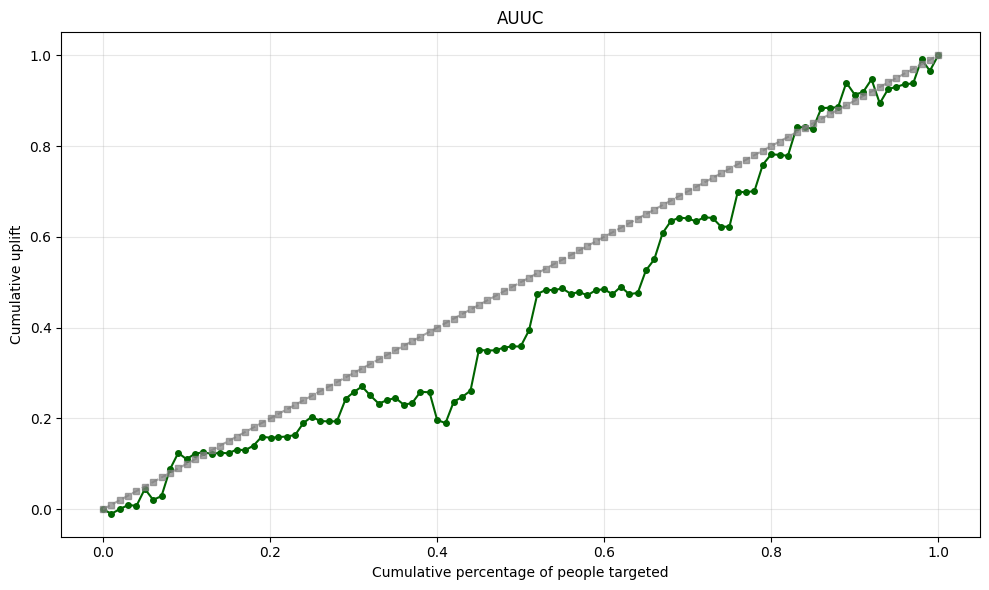

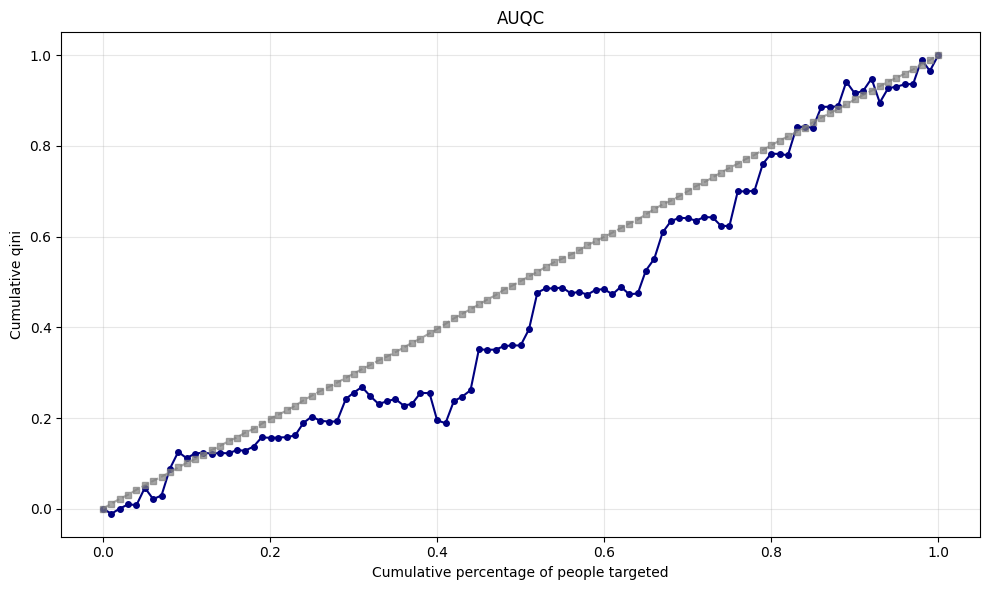

----------------------------------------
AUUC:  0.4376021324837136
AUQC:  0.43748771680208054
Lift:  0.8819526433944702
KRCC:  -0.035216200941439374
seed: 340487


In [ ]:
print ("Evaluating baseline🔃🔃🔃")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_men_test_t_on_device = x_men_test_t.to(device)

y0_pred, y1_pred, _,_ = dragonnet.predict(x_men_test_t_on_device)

# Move predicted tensors back to CPU before converting to numpy arrays
uplift_pred = (y1_pred - y0_pred).cpu().numpy().flatten()

y_true = y_men_test_t.cpu().numpy().flatten() # Ensure true labels are also on CPU if they were ever moved
t_true = t_men_test_t.cpu().numpy().flatten() # Ensure true treatments are also on CPU if they were ever moved

auuc_score = auuc(y_true, t_true, uplift_pred, bins=100, plot=True)
auqc_score = auqc(y_true, t_true, uplift_pred, bins=100, plot=True)
lift_score = lift(y_true, t_true, uplift_pred, h=0.3)
krcc_score = krcc(y_true, t_true, uplift_pred, bins= 100)

print ("-"*40)
print ("AUUC: ", auuc_score)
print ("AUQC: ", auqc_score)
print ("Lift: ", lift_score)
print ("KRCC: ", krcc_score)
print (f"seed: {seed}")